# SBPPC Example Fitting
This notebook demonstrates how to generate synthetic polarimetric data, fit it with various models, and perform MCMC analysis using `sbppc`.

In [1]:

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sbppc import PPCModel, ppc_le, alpha_min_le
from sbppc.tool_emcee import run_emcee, corner_plot, trace_plot, calc_derived_samples

# Ensure sbppc is in path if running locally
if os.path.abspath("..") not in sys.path:
    sys.path.insert(0, os.path.abspath(".."))


## 1. Generate Synthetic Data (Linear-Exponential)
We generate synthetic data using the **Linear-Exponential (LE)** model as the "Truth".

<>:27: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\m'
/var/folders/wr/2dfdz2595pbfdb_9zm9p_w100000gn/T/ipykernel_30540/788294207.py:27: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("Properly-rotated Polarization ($P_\mathrm{r}$) [%]")


True Derived: alpha_min=8.39, P_min=-1.38


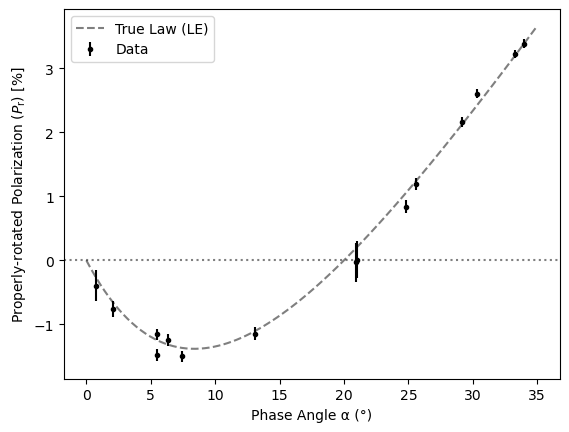

In [2]:

# True Parameters (LE)
h_true = 0.2
a0_true = 20.0
k_true = 10.0
theta_true = [h_true, a0_true, k_true]

# Calculate True Derived Parameters
amin_true = alpha_min_le(a0=a0_true, k=k_true)
pmin_true = ppc_le(amin_true, *theta_true)
print(f"True Derived: alpha_min={amin_true:.2f}, P_min={pmin_true:.2f}")

# Observations (0 to 35 degrees) - 15 points
np.random.seed(42)
x_obs = np.sort(np.random.uniform(0, 35, 15))
y_true = ppc_le(x_obs, *theta_true)

# Error Model: 0.05 / |y| + 0.05
y_err = 0.05 / (np.abs(y_true) + 1e-5) + 0.05
y_obs = y_true + np.random.normal(0, y_err, len(x_obs))

plt.errorbar(x_obs, y_obs, yerr=y_err, fmt='k.', label='Data')
x_plot = np.linspace(0, 35, 100)
plt.plot(x_plot, ppc_le(x_plot, *theta_true), 'k--', label='True Law (LE)', alpha=0.5)
plt.axhline(0, color='k', linestyle=':', alpha=0.5)

plt.xlabel("Phase Angle α (°)")
plt.ylabel("Properly-rotated Polarization ($P_\mathrm{r}$) [%]")
plt.legend()
plt.show()


## 2. Least-Squares Fitting
We fit the data with multiple models: LE, SH3, SH5, LM_B, and LM_F.


<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
/var/folders/wr/2dfdz2595pbfdb_9zm9p_w100000gn/T/ipykernel_30540/1217990278.py:29: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel("Properly-rotated Polarization ($P_\mathrm{r}$) [%]")
/Users/ysbach/Dropbox/github/sbppc/sbppc/functions.py:383: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  mini = minimize_scalar(fun, args=tuple(np.atleast_1d(theta)), **kwargs)


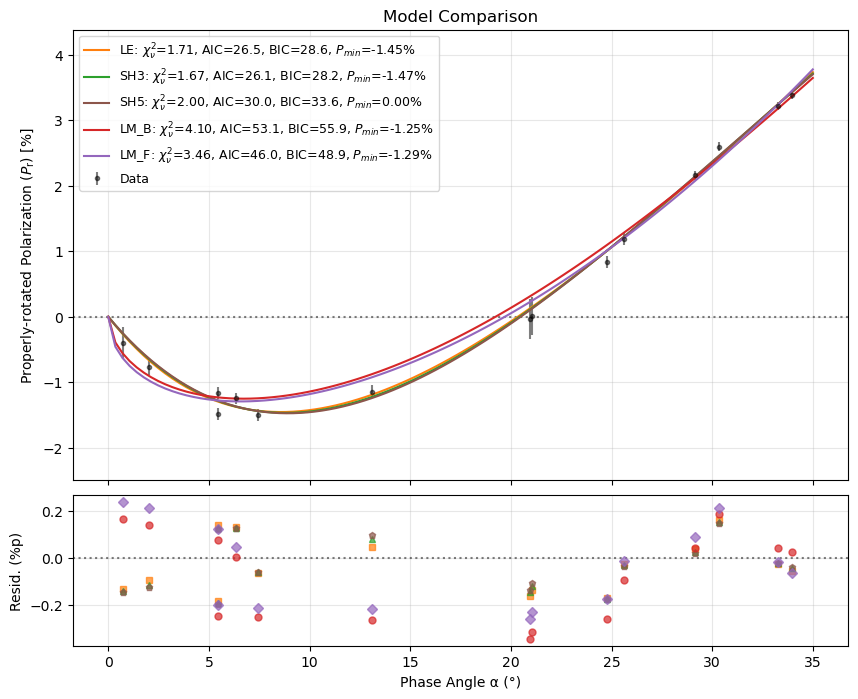

In [3]:

models = ["le", "sh3", "sh5", "lm_b", "lm_f"]
colors = ["C1", "C2", "C5", "C3", "C4"]
markers = ["s", "^", "p", "o", "D"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0.05)

ax1.errorbar(x_obs, y_obs, yerr=y_err, fmt='k.', alpha=0.5, label='Data')
ax1.axhline(0, color='k', linestyle=':', alpha=0.5)
ax2.axhline(0, color='k', linestyle=':', alpha=0.5)

x_plot = np.linspace(0, 35, 100)

for name, color, m in zip(models, colors, markers):
    model = PPCModel(name)
    model.solve_lsq(x_obs, y_obs, yerr=y_err)

    bic = model.bic_lsq
    aic = model.aic_lsq
    rchi2 = getattr(model, "chi2_red_lsq", getattr(model, "red_chi2_lsq", 0))

    label = rf"{name.upper()}: $\chi^2_\nu$={rchi2:.2f}, AIC={aic:.1f}, BIC={bic:.1f}, $P_{{min}}$={model.pmin_lsq:.2f}%"
    ax1.plot(x_plot, model.fun_lsq(x_plot), color=color, label=label)

    resid = y_obs - model.fun_lsq(x_obs)
    ax2.plot(x_obs, resid, m, color=color, alpha=0.7, markersize=5)

ax1.legend(fontsize=9)
ax1.set_ylabel("Properly-rotated Polarization ($P_\mathrm{r}$) [%]")
ax1.set_title("Model Comparison")
ax1.grid(True, alpha=0.3)
ax1.set_ylim(min(y_obs)-1, max(y_obs)+1)

ax2.set_ylabel("Resid. (%p)")
ax2.set_xlabel("Phase Angle α (°)")
ax2.grid(True, alpha=0.3)

plt.show()


## 3. MCMC Analysis (LE Model)

100%|██████████| 3000/3000 [00:06<00:00, 472.39it/s]


Flat samples shape: (6400, 3)


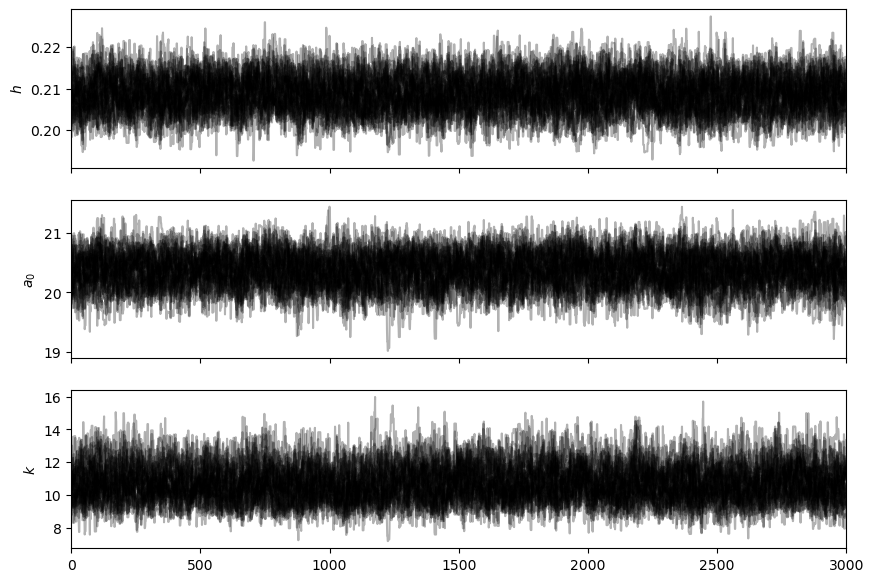

In [4]:

model_mcmc = PPCModel("le")
sampler = run_emcee(model_mcmc, x_obs, y_obs, y_err, nwalkers=32, nsteps=3000, parallel=True)

samples = sampler.get_chain(discard=500)
flat_samples = sampler.get_chain(discard=500, flat=True, thin=15)
print(f"Flat samples shape: {flat_samples.shape}")

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
labels = [r"$h$", r"$a_0$", r"$k$"]
trace_plot(axes, samples, labels=labels)
plt.show()


## 4. Derived Parameters & Corner Plot

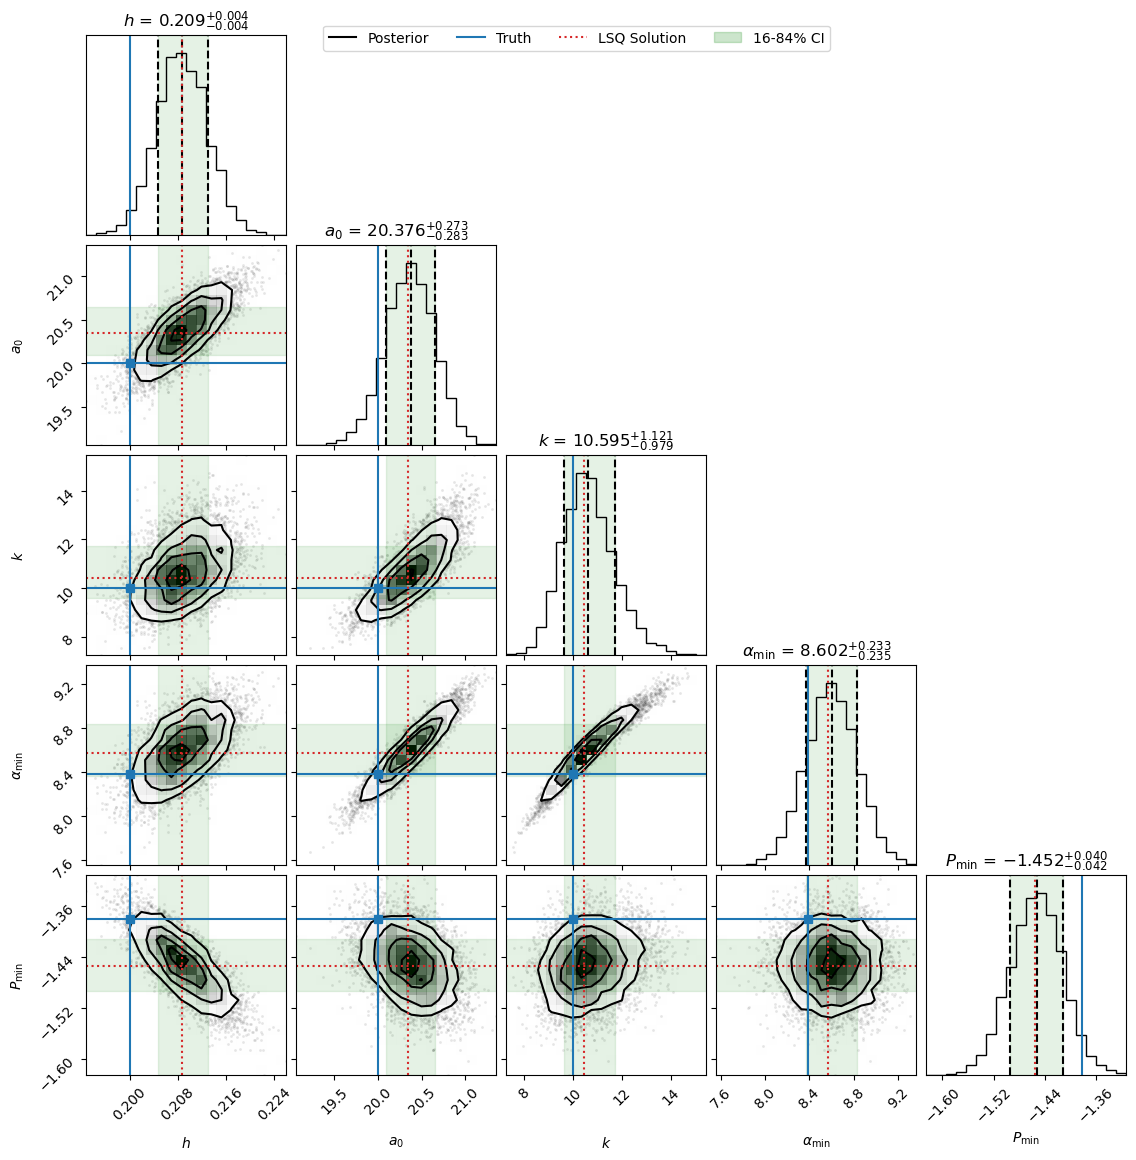

In [5]:

derived = calc_derived_samples(model_mcmc, flat_samples)

samples_all = np.column_stack([
    flat_samples,
    derived["alpha_min"],
    derived["p_min"]
])

labels_all = labels + [r"$\alpha_{\min}$", r"$P_{\min}$"]
truths_all = theta_true + [amin_true, pmin_true]

# Corner Plot
fig = corner_plot(
    samples_all,
    labels=labels_all,
    truths=truths_all,
    truth_color='C0',
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".3f"
)

# Calculate 16-84 percentiles for axvspan
percentiles = np.percentile(samples_all, [16, 84], axis=0)

# Get axes grid
ndim = samples_all.shape[1]
axes = np.array(fig.axes).reshape((ndim, ndim))

# LSQ Solution
if hasattr(model_mcmc, "theta_lsq"):
    lsq_vals = np.concatenate([model_mcmc.theta_lsq, [model_mcmc.amin_lsq, model_mcmc.pmin_lsq]])

    for i in range(ndim):
        for j in range(i + 1):
            ax = axes[i, j]
            # Add axvspan for 16-84% interval (green shaded region)
            ax.axvspan(percentiles[0, j], percentiles[1, j], color='g', alpha=0.1)
            # LSQ lines
            ax.axvline(lsq_vals[j], color='C3', ls=':', lw=1.5)
            if i != j:
                ax.axhspan(percentiles[0, i], percentiles[1, i], color='g', alpha=0.1)
                ax.axhline(lsq_vals[i], color='C3', ls=':', lw=1.5)

# Legend (centered)
h_post = mlines.Line2D([], [], color='k', label='Posterior')
h_truth = mlines.Line2D([], [], color='C0', label='Truth')
h_lsq = mlines.Line2D([], [], color='C3', ls=':', label='LSQ Solution')
import matplotlib.patches as mpatches
h_ci = mpatches.Patch(color='g', alpha=0.2, label='16-84% CI')

fig.legend(handles=[h_post, h_truth, h_lsq, h_ci], loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=4, fontsize=10)

plt.show()


## 5. Posterior Predictive Plot

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
/var/folders/wr/2dfdz2595pbfdb_9zm9p_w100000gn/T/ipykernel_30540/132917517.py:22: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("Properly-rotated Polarization ($P_\mathrm{r}$) [%]")


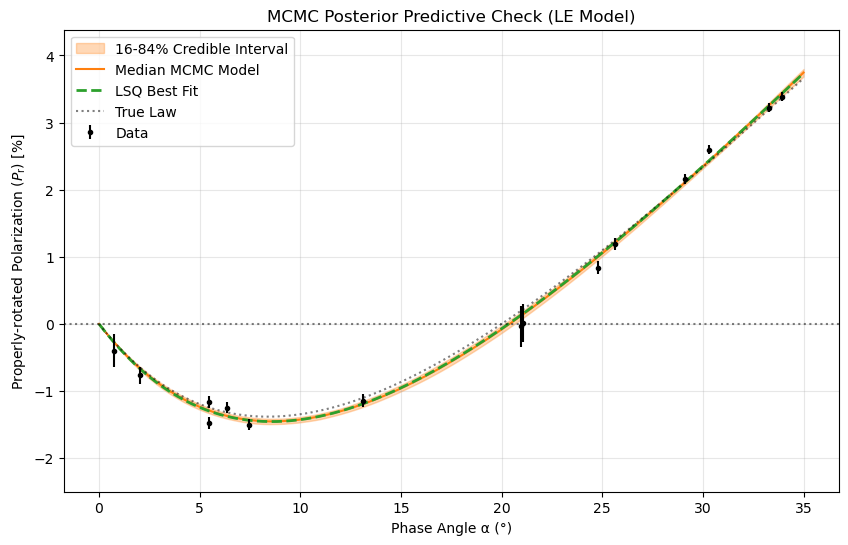

In [6]:

n_draws = 500
inds = np.random.randint(len(flat_samples), size=n_draws)
subset = flat_samples[inds]

x_plot = np.linspace(0, 35, 100)
y_models = np.array([model_mcmc.fun(x_plot, *theta) for theta in subset])

y16, y50, y84 = np.percentile(y_models, [16, 50, 84], axis=0)

plt.figure(figsize=(10, 6))
plt.fill_between(x_plot, y16, y84, color='C1', alpha=0.3, label='16-84% Credible Interval')
plt.plot(x_plot, y50, color='C1', label='Median MCMC Model')

if hasattr(model_mcmc, "theta_lsq"):
    plt.plot(x_plot, model_mcmc.fun(x_plot, *model_mcmc.theta_lsq), 'C2--', lw=2, label='LSQ Best Fit')

plt.axhline(0, color='k', linestyle=':', alpha=0.5)
plt.errorbar(x_obs, y_obs, yerr=y_err, fmt='k.', label='Data')
plt.plot(x_plot, ppc_le(x_plot, *theta_true), 'k:', alpha=0.5, label='True Law')

plt.xlabel("Phase Angle α (°)")
plt.ylabel("Properly-rotated Polarization ($P_\mathrm{r}$) [%]")
plt.title("MCMC Posterior Predictive Check (LE Model)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(min(y_obs)-1, max(y_obs)+1)
plt.show()
